In [1]:
import os
import nnmnkwii.datasets.jvs
from nnmnkwii.io import hts
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchaudio
import pytorch_lightning as pl
import itertools
from matplotlib import pyplot as plt
import pyworld as pw
import pysptk as ps
import numpy as np

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sklearn as sk

# model

In [3]:
from model.child import Encoder, Decoder, Discriminator

In [4]:
from model.main import SplitterNet

# data

## transform

In [5]:
from data.dataset import TransSqueeze, TransChunked

## dataset

In [6]:
from data.dataset import JVSDataset

# 入力確認

In [7]:
model = SplitterNet()
model.test_input()

encoder out *2
torch.Size([64, 64, 4, 4])
decoder out
torch.Size([64, 1, 32, 32])


# eval

In [8]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()
    print(waveform.shape)
    num_channels, num_frames = waveform.shape
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [9]:
import glob
pa = glob.glob("logs/lightning_logs/version_55/checkpoints/epoch=*.ckpt")[-1]

In [10]:
model = model.load_from_checkpoint(pa)

In [11]:
model.eval()

SplitterNet(
  (content_encoder): Encoder(
    (lr): LeakyReLU(negative_slope=0.02)
    (conv1): Conv2d(1, 8, kernel_size=(3, 9), stride=(2, 2), padding=(1, 4), bias=False)
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(8, 16, kernel_size=(3, 9), stride=(2, 2), padding=(1, 4), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 9), stride=(2, 2), padding=(1, 4), bias=False)
    (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(32, 32, kernel_size=(3, 9), stride=(1, 1), padding=(1, 4), bias=False)
    (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (attribute_encoder): Encoder(
    (lr): LeakyReLU(negative_slope=0.02)
    (conv1): Conv2d(1, 8

In [12]:
root = os.path.join("../",  'jvs_r9y9_ver1')
wav_paths = nnmnkwii.datasets.jvs.WavFileDataSource(root, categories=["parallel"])

In [13]:
x = torchaudio.load(wav_paths.collect_files()[101])[0][:, :159377]
tmp = torchaudio.load(wav_paths.collect_files()[303])[0]

In [14]:
def ex_mc(x):
    f0, sp, ap = pw.wav2world(x.squeeze(0).to(torch.double).numpy(), 24000)
    mc = ps.sp2mc(sp, order=31, alpha=ps.util.mcepalpha(24000))
    mc = torch.from_numpy(mc.T)
    return mc, f0, sp, ap

In [15]:
def synth(mc, f0, ap):
    mc = mc.T.numpy()
    sp = ps.mc2sp(mc, alpha=ps.util.mcepalpha(24000), fftlen=1024)
    sp = sp.astype(np.double)[:len(f0)]
    print(sp)
    return pw.synthesize(f0, sp, ap, 24000)

## 元音声の再合成

In [16]:
x_mc, x_f0, x_sp, x_ap = ex_mc(x)
xx = synth(x_mc, x_f0, x_ap)

[[3.43263472e-07 3.38804166e-07 3.27037883e-07 ... 8.59406536e-10
  8.60750018e-10 8.61197580e-10]
 [2.83185086e-08 2.80881946e-08 2.74722759e-08 ... 4.84565467e-10
  4.84599612e-10 4.84611025e-10]
 [1.73742962e-07 1.73785936e-07 1.73964547e-07 ... 7.16355213e-10
  7.15567887e-10 7.15305561e-10]
 ...
 [7.62090563e-02 7.69638416e-02 7.90911238e-02 ... 5.37048994e-09
  5.32647394e-09 5.31186926e-09]
 [8.45239240e-02 8.65366954e-02 9.24017955e-02 ... 4.95329253e-10
  4.91485538e-10 4.90210168e-10]
 [8.14201198e-02 8.13264307e-02 8.11581543e-02 ... 2.31427883e-08
  2.30937250e-08 2.30773777e-08]]


In [17]:
import IPython.display
IPython.display.Audio(xx, rate=24000)

(1, 159480)


/tmp/ipykernel_2009525/2825384265.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  plot_specgram(torch.tensor([xx]), sample_rate=24000, title="Original")


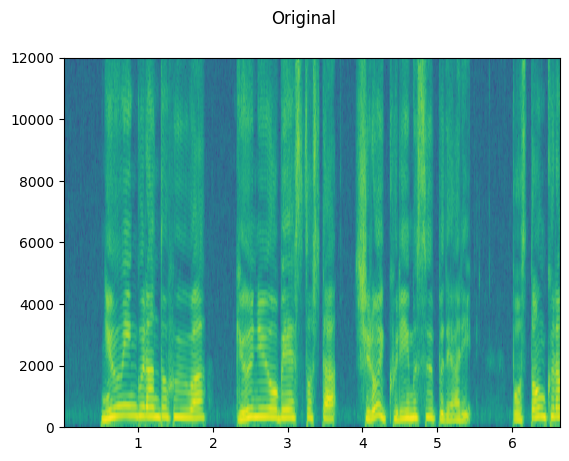

In [18]:
plot_specgram(torch.tensor([xx]), sample_rate=24000, title="Original")

In [19]:
tmp_mc, tmp_f0, tmp_sp, tmp_ap = ex_mc(tmp)
tmptmp = synth(tmp_mc, tmp_f0, tmp_ap)

[[7.02180667e-08 7.00443101e-08 6.95854043e-08 ... 9.82380389e-11
  9.80887072e-11 9.80389366e-11]
 [2.98516171e-07 2.95934698e-07 2.89054637e-07 ... 8.77787991e-10
  8.78143998e-10 8.78262221e-10]
 [4.73407771e-07 4.74911065e-07 4.79210260e-07 ... 9.34613738e-10
  9.31850976e-10 9.30930666e-10]
 ...
 [3.54152940e-07 3.55410130e-07 3.58947153e-07 ... 5.82273243e-10
  5.81400450e-10 5.81109672e-10]
 [1.82641909e-06 1.81116693e-06 1.77121180e-06 ... 5.57291343e-10
  5.56669428e-10 5.56462237e-10]
 [1.03925568e-06 1.03729368e-06 1.03215422e-06 ... 6.45207469e-10
  6.43359525e-10 6.42744137e-10]]


In [20]:
import IPython.display
IPython.display.Audio(tmptmp, rate=24000)

(1, 159480)


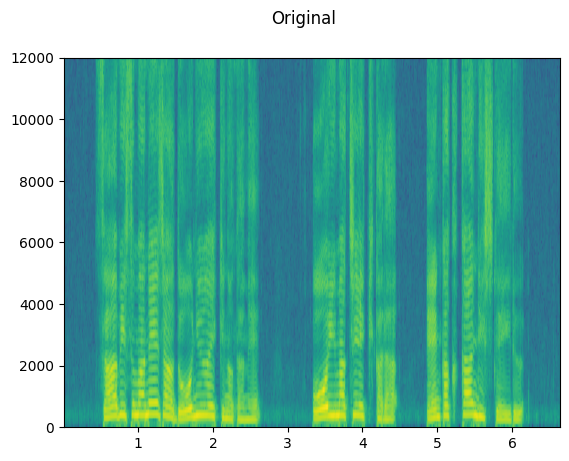

In [21]:
plot_specgram(torch.tensor([tmptmp]), sample_rate=24000, title="Original")

## 元音声の変換再合成

In [22]:
y_mc = model(x_mc.unsqueeze(0).unsqueeze(0).to(torch.float), tmp_mc.unsqueeze(0).unsqueeze(0).to(torch.float)).squeeze(0).squeeze(0)
y_mc = y_mc.detach()

In [23]:
yy = synth(y_mc, x_f0, x_ap)

[[1.92297648e-07 1.93960020e-07 1.98607580e-07 ... 4.07056198e-13
  4.06791110e-13 4.06702721e-13]
 [1.14289342e-07 1.14897219e-07 1.16549089e-07 ... 7.39261679e-13
  7.38941297e-13 7.38834341e-13]
 [1.16188295e-08 1.18229515e-08 1.24259438e-08 ... 5.13569222e-13
  5.12887259e-13 5.12659956e-13]
 ...
 [2.40033037e-12 2.51207648e-12 2.85876487e-12 ... 3.31831662e-14
  3.30034529e-14 3.29437134e-14]
 [9.42199986e-13 1.03274464e-12 1.34330470e-12 ... 4.49107331e-13
  4.48130953e-13 4.47805530e-13]
 [5.48332074e-11 5.80374845e-11 6.82829002e-11 ... 9.31523522e-12
  9.29087710e-12 9.28276553e-12]]


In [24]:
import IPython.display
IPython.display.Audio(yy, rate=24000)

(1, 159480)


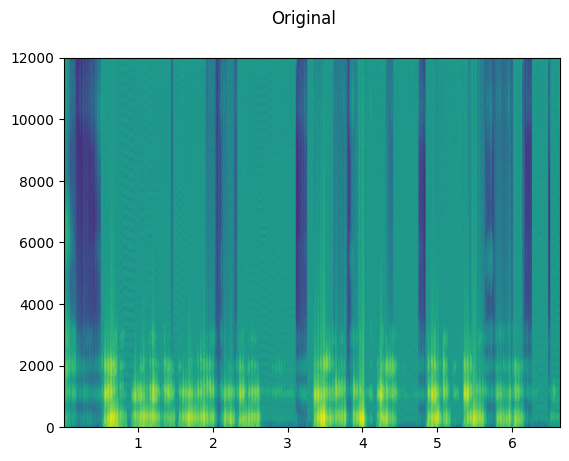

In [25]:
plot_specgram(torch.tensor([yy]), sample_rate=24000, title="Original")